## GeekBrains / Машинное обучение в бизнесе

## Домашнее задание А.Николаев / Урок 2. Кейс 1. Преобразование признаков

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

### Задача №1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings

import numpy as np
import pandas as pd 

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [4]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [5]:
def add_feature(df, p):
    _df = df.copy(deep=True)
    for i in range(p):
        _df[f't{i}'] = 0
        _df.iloc[i+1:, i+1] = _df.iloc[:(i+1)*(-1), 0].values
    _df.fillna(0)
    return _df

In [6]:
def split_data(df, split_date):
    return df.loc[df.index.get_level_values('Date') <= split_date].copy(), \
           df.loc[df.index.get_level_values('Date') >  split_date].copy()

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [9]:
df.tail()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2018-08-02,20:00:00,44057.0,2018,8,2,3,214,31,3,20,0,0,0
2018-08-02,21:00:00,43256.0,2018,8,2,3,214,31,3,21,0,0,0
2018-08-02,22:00:00,41552.0,2018,8,2,3,214,31,3,22,0,0,0
2018-08-02,23:00:00,38500.0,2018,8,2,3,214,31,3,23,0,0,0
2018-08-03,00:00:00,35486.0,2018,8,3,3,215,31,4,0,0,0,0


In [10]:
df.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


##### Общий вид изменения потребления энергии по ряду + resampling month + resampling year

In [11]:
df_day =  df.resample('D').mean()
df_month = df.resample('M').mean()
df_year =  df.resample('Y').mean()

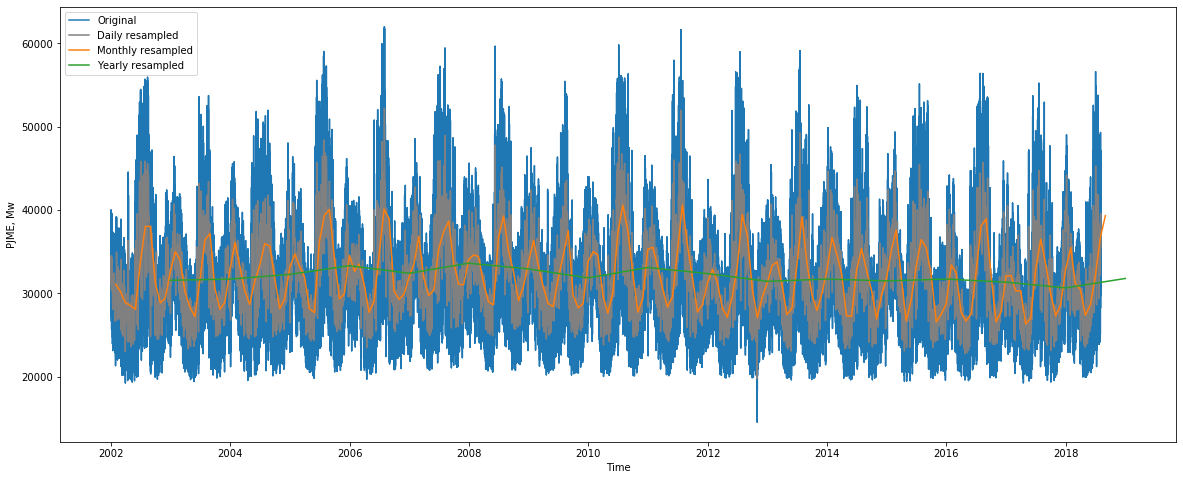

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(df['PJME_MW'], label='Original')
plt.plot(df_day['PJME_MW'], label='Daily resampled', color='grey')
plt.plot(df_month['PJME_MW'], label='Monthly resampled')
plt.plot(df_year['PJME_MW'], label='Yearly resampled')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()

##### Для наглядности и улучшения визуализации, возьмем данные за период в 1 год (например с 2004 по 2005 год)

In [13]:
df2004_day = df_day.loc['2004-01-01':'2004-12-31']

##### Посмотрим, что произойдёт, если мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные

In [14]:
alpha = 0.3
df2004_day_exp1_03 = exponential_smoothing(df2004_day['PJME_MW'], alpha)
alpha = 0.05
df2004_day_exp1_005 = exponential_smoothing(df2004_day['PJME_MW'], alpha)

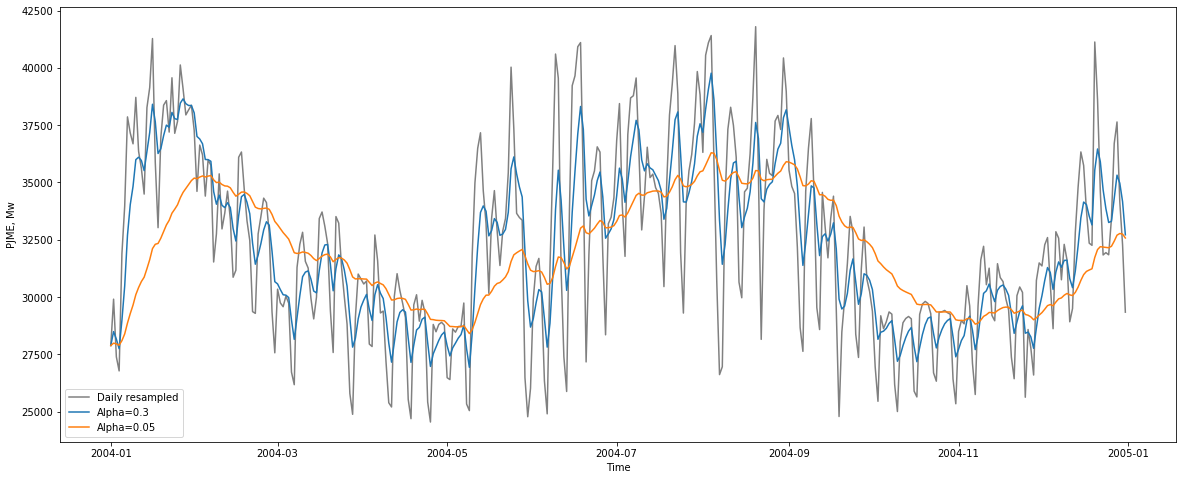

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(df2004_day['PJME_MW'], label='Daily resampled', color='gray')
plt.plot(df2004_day.index, df2004_day_exp1_03, label='Alpha=0.3')
plt.plot(df2004_day.index, df2004_day_exp1_005, label='Alpha=0.05')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()

##### Чем меньше коэффициент alpha при экспоненциальном сглаживании, тем более сглаженным будет ряд.

##### Построим график за 2004 год с оригинальными данными, сглаженным рядом и рядом без сезонных зависимостей

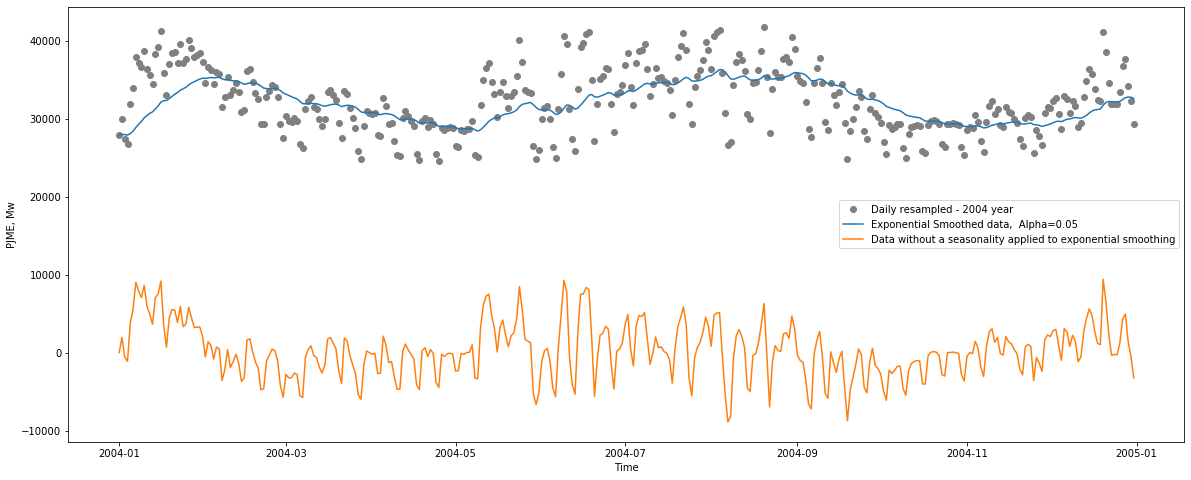

In [16]:
plt.figure(figsize=(20, 8))
plt.plot(df2004_day['PJME_MW'], 'o', label='Daily resampled - 2004 year', color='gray')
plt.plot(df2004_day.index, df2004_day_exp1_005, label='Exponential Smoothed data,  Alpha=0.05')
plt.plot(df2004_day.index, df2004_day['PJME_MW'].values - df2004_day_exp1_005, 
         label='Data without a seasonality applied to exponential smoothing')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()

##### Т.к. по заданию нам надо предсказывать экспоненциально сглаженный ряд, то создадим его, назвав df_data. За основу возбмем alpha = 0.05. Все остальные данные из оригинального рядя нам на данном этапе не понадобятся, поэтому только df_day['PJME_MW']

In [17]:
df_data = pd.DataFrame(exponential_smoothing(df_day['PJME_MW'], alpha), index=df_day.index)
df_data.head()

,0
Date,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


##### Построим признаки для нашей будущем модели. По условию задачи добавим историю на глубину 3-х измерений от текущего (р=3)

In [18]:
p = 3
df_data = add_feature(df_data, p)
df_data.head()

,0,t0,t1,t2
Date,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257


In [19]:
train, test = split_data(df_data, '2017-08-03')

In [20]:
h = 1 # горизонт прогноза = 1
X_train1 = train.iloc[:-h,:]
y_train1 = train[df_data.columns[0]].values[h:]
X_test1 = test.iloc[:-h,:]
y_test1 = test[df_data.columns[0]].values[h:]

##### Построим график данных, разбирых на train и test

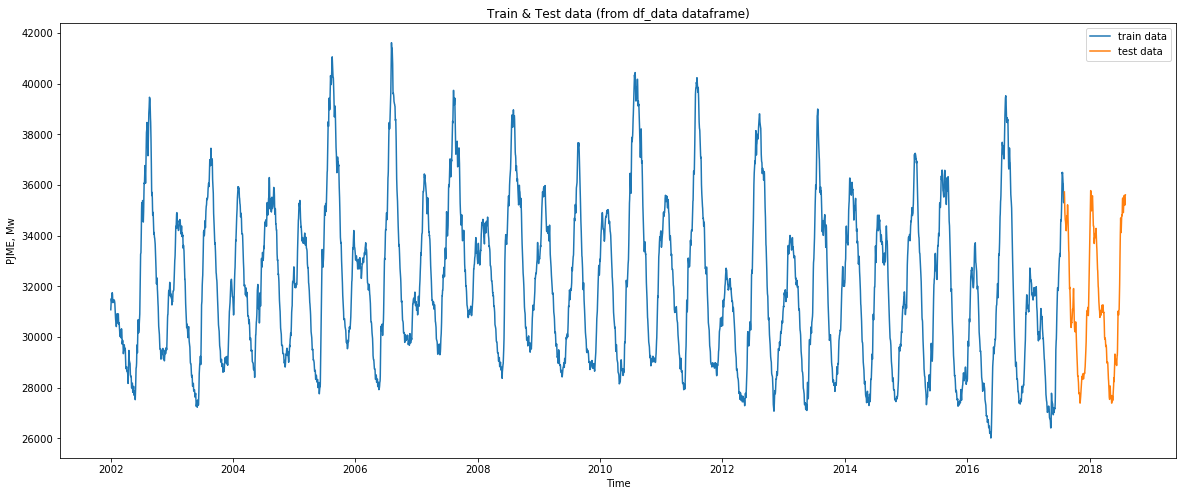

In [21]:
plt.figure( figsize=(20, 8))
plt.plot(train.index.get_level_values('Date'), train[df_data.columns[0]], label='train data')
plt.plot(test.index.get_level_values('Date'), test[df_data.columns[0]], label='test data')
plt.title('Train & Test data (from df_data dataframe)')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()

In [22]:
scaler1 = StandardScaler()
X_train1 = scaler1.fit_transform(X_train1)
X_test1 = scaler1.transform(X_test1)

In [23]:
model_gb1 = GradientBoostingRegressor(max_depth=10, random_state=42, n_estimators=100)

In [24]:
model_gb1.fit(X_train1, y_train1) 
X_test_pred_gb1 = model_gb1.predict(X_test1)

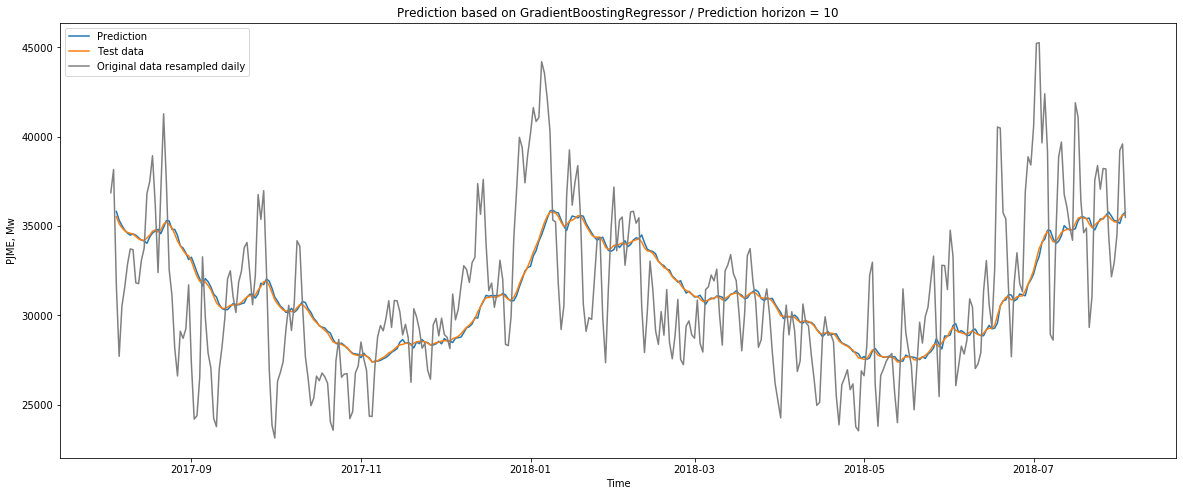

Ошибка предсказания на основе модели градиентного бустинга: 0.360509615336538 %


In [25]:
plt.figure(figsize=(20, 8))
plt.plot(test.index[h:], X_test_pred_gb1, label='Prediction')
plt.plot(test.index[h:], y_test1, label='Test data')
plt.plot(df_day.loc['2017-08-03':].index, df_day.loc['2017-08-03':]['PJME_MW'], label='Original data resampled daily', 
         color='gray')
plt.title('Prediction based on GradientBoostingRegressor / Prediction horizon = 10')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()
er_gb1 = mean_absolute_percentage_error(y_true=y_test1, y_pred=X_test_pred_gb1)
print(f'Ошибка предсказания на основе модели градиентного бустинга: {er_gb1} %')

In [26]:
h = 10 # горизонт прогноза = 10
X_train10 = train.iloc[:-h,:]
y_train10 = train[df_data.columns[0]].values[h:]
X_test10 = test.iloc[:-h,:]
y_test10 = test[df_data.columns[0]].values[h:]

In [27]:
scaler10 = StandardScaler()
X_train10 = scaler10.fit_transform(X_train10)
X_test10 = scaler10.transform(X_test10)

In [28]:
model_gb10 = GradientBoostingRegressor(max_depth=10, random_state=42, n_estimators=100)

In [29]:
model_gb10.fit(X_train10, y_train10) 
X_test_pred_gb10 = model_gb10.predict(X_test10)

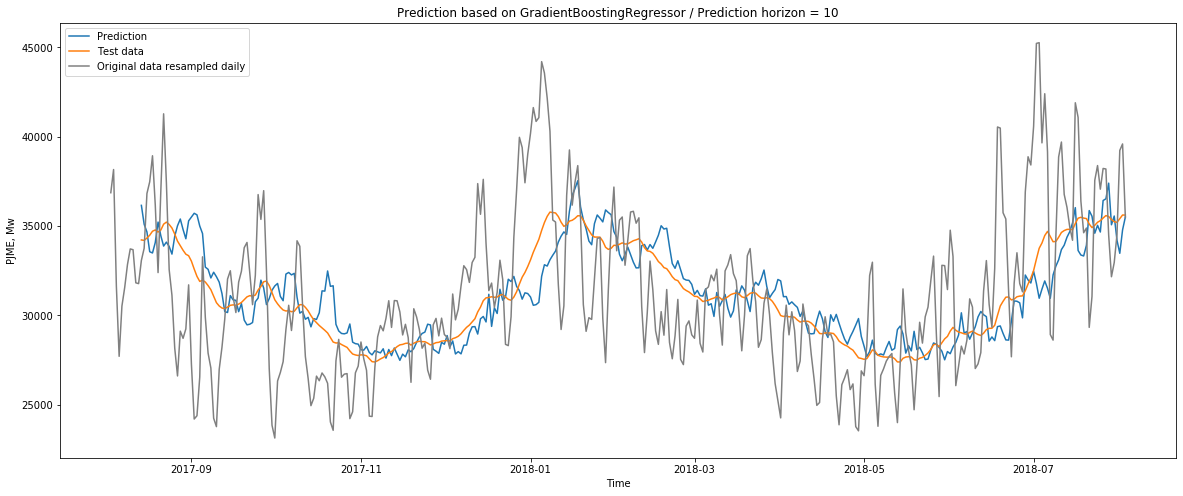

Ошибка предсказания на основе модели градиентного бустинга: 2.8861978733415543 %


In [30]:
plt.figure(figsize=(20, 8))
plt.plot(test.index[h:], X_test_pred_gb10, label='Prediction')
plt.plot(test.index[h:], y_test10, label='Test data')
plt.plot(df_day.loc['2017-08-03':].index, df_day.loc['2017-08-03':]['PJME_MW'], label='Original data resampled daily', 
         color='gray')
plt.title('Prediction based on GradientBoostingRegressor / Prediction horizon = 10')
plt.ylabel('PJME, Mw')
plt.xlabel('Time')
plt.legend()
plt.show()
er_gb10 = mean_absolute_percentage_error(y_true=y_test10, y_pred=X_test_pred_gb10)
print(f'Ошибка предсказания на основе модели градиентного бустинга: {er_gb10} %')

### Задача №2. Оцените ошибку модели из п.1.

In [31]:
df_day = add_feature(df_day, p)
train, test = split_data(df_day, '2017-08-03')
h=1
y_test1 = test[df_day.columns[0]].values[h:]
h=10
y_test10 = test[df_day.columns[0]].values[h:]
er_gb1_df_day = mean_absolute_percentage_error(y_true=y_test1, y_pred=X_test_pred_gb1)
er_gb10_df_day = mean_absolute_percentage_error(y_true=y_test10, y_pred=X_test_pred_gb10)
print(f'Ошибка предсказания для экспоненциальной сглаженной на основе модели градиентного бустинга: {er_gb1} %')
print(f'Ошибка предсказания для оригинальных данных на основе модели градиентного бустинга: {er_gb1_df_day} %')
print()
print(f'Ошибка предсказания для экспоненциальной сглаженной на основе модели градиентного бустинга: {er_gb10} %')
print(f'Ошибка предсказания для оригинальных данных на основе модели градиентного бустинга: {er_gb10_df_day} %')

Ошибка предсказания для экспоненциальной сглаженной на основе модели градиентного бустинга: 0.360509615336538 %
Ошибка предсказания для оригинальных данных на основе модели градиентного бустинга: 9.024034079725014 %

Ошибка предсказания для экспоненциальной сглаженной на основе модели градиентного бустинга: 2.8861978733415543 %
Ошибка предсказания для оригинальных данных на основе модели градиентного бустинга: 10.726851512288818 %


##### Как видно, для оригинальных данных ошибка предсказания еще выше, чем для экспоненциально сглаженных данных

### Задача №3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

##### При увеличении грубины горизонта предсказания, увеличивается ошибка предсказания, как на оригинальных, так и на сглаженных данных.

### Задача №4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :);

    б) Количество денег, которые тратят покупатели в интернет магазине;

    в) Вес растущего котенка;

    г) Прирост объема деревьев в лесу от времени.

### Ответ

a) Нестационарный, т.к. из-за глобального потепления (или наструпления очередного ледникового периода) наблюдается тренд. Цикличный, сезонный.

б) Нестационарный, т.к. возможен тренд из-за общих экономических условий или рекламных компаний интернет-магазина. Сезонный, т.к. перед и в праздничные дни покупок больше. Цикличный под вопросом, скорее нет.

в) Нестационарный, т.к. явный тренд на увеличение веса/роста. Сезонный, т.к. осенью на зиму вес набирается, весной и летом вес сбрасывается. Цикличности скорее всего нет.

г) Стационарный, т.к невозможно выявить явного тренда, все зависит от условий. Сезонный - однозначно, цикличный - скорее всего да.

### Задача №5. Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)

### Ответ

Т.к. по определению, стационарный рад это ряд, в котором отсутствует тренд, то на первый взгляд стационарными рядами являются: (b), (d), (g), (h)